# ML Prediction: Predicting Residential Real Estate Prices

**Objective:** Build machine learning models to predict residential property prices in Slovenia.

**Models:**
- Linear Regression (baseline)
- Random Forest Regressor
- Gradient Boosting Regressor

**Evaluation:** Cross-validation, hyperparameter tuning, feature importance

## Introduction to Machine Learning for Price Prediction

**What is Machine Learning (ML)?**
ML creates mathematical models that learn patterns from data without explicit programming. Instead of writing "if-then" rules, we show the computer examples and it learns to predict.

**Three models we'll compare:**
1. **Linear Regression**: Fits a straight line to data (simple, interpretable)
2. **Random Forest**: Combines many decision trees (handles non-linear patterns)
3. **Gradient Boosting**: Improves predictions iteratively (often most accurate)

**The ML workflow:**
1. Prepare data (features = input variables, target = what we predict)
2. Split into training (80%) and testing (20%) sets
3. Train each model on training data
4. Evaluate on testing data
5. Compare performance metrics
6. Make future predictions

### Step 1: Imports, setup, and data loading

What this does next:
- Imports core libraries for data handling (NumPy, pandas), plotting (Matplotlib, Seaborn), and machine learning (scikit‑learn).
- Configures logging so progress and warnings are printed consistently.
- Loads the processed dataset (`quarterly_construction_data_with_sales.csv`), parses the `date` column, sorts by time, and previews the data.

Key terms in context:
- Feature: input variable used to predict (e.g., permits, sales, price lag).
- Target: value we want to predict (average price in EUR).
- DataFrame: a table (rows × columns) used throughout the analysis.

Why this matters:
- Reproducible imports/config ensure consistent runs across machines.
- Time sorting is essential for any time‑series‑aware train/test split and later forecasting.

In [24]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import pickle

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

sys.path.insert(0, str(Path(".").resolve().parent))
from helpers.data_processing import load_csv_file

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Load data
data_path = Path("../data/processed/quarterly_construction_data_with_sales.csv")
df = load_csv_file(str(data_path))

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

logger.info(f"Loaded {df.shape[0]} quarters of data")
display(df.head())

INFO:helpers.data_processing:Loaded CSV from ../data/processed/quarterly_construction_data_with_sales.csv using utf-8 encoding
INFO:__main__:Loaded 48 quarters of data
INFO:__main__:Loaded 48 quarters of data


,date,num_building_permits,construction_cost_index,num_residential_sales,avg_price_eur
0,2013-01-01,869.0,83.5,2345.0,80492.968443
1,2013-04-01,919.0,80.1,2601.0,82566.322568
2,2013-07-01,847.0,81.7,2008.0,77141.554283
3,2013-10-01,808.0,79.4,2285.0,74166.764114
4,2014-01-01,729.0,81.7,2345.0,71928.062687


### Step 2: Feature engineering — lags and moving averages

What this does next:
- Copies the raw DataFrame and normalizes any legacy column names.
- Defines the prediction target (`avg_price_eur`).
- Builds a compact set of predictive features:
  - Lags: previous price (1 and 4 quarters) and previous permits/sales (1 quarter) to encode momentum and seasonality.
  - Moving averages (4‑quarter): smooth prices, permits, and costs to reduce noise.
- Drops rows with missing values created by shifting/rolling and prints basic feature stats.

Why we keep the feature set small:
- With ~40–50 quarterly samples, too many features can cause overfitting. A concise, high‑signal feature set improves generalization.

Key terms:
- Lag: value from a previous time step (e.g., price one quarter ago).
- Moving average: rolling mean over a fixed window (here 4 quarters) to capture trend and reduce noise.

In [25]:
# Create feature matrix
df_features = df.copy()

# Normalize legacy column name if present
if 'num_buildings' in df_features.columns:
    df_features = df_features.rename(columns={'num_buildings': 'num_building_permits'})

# Target variable
target = 'avg_price_eur'

# Core features (direct from data)
feature_cols = ['num_building_permits', 'construction_cost_index', 'num_residential_sales']

# Create lag features (only most important ones to avoid overfitting)
df_features['price_lag1'] = df_features[target].shift(1)
df_features['price_lag4'] = df_features[target].shift(4)  # Year-over-year

# Create lag for input variables (most recent market signals)
df_features['permits_lag1'] = df_features['num_building_permits'].shift(1)
df_features['sales_lag1'] = df_features['num_residential_sales'].shift(1)

# Create ONLY essential moving averages (reduce feature count)
df_features['price_ma4'] = df_features[target].rolling(window=4).mean()
df_features['permits_ma4'] = df_features['num_building_permits'].rolling(window=4).mean()
df_features['cost_ma4'] = df_features['construction_cost_index'].rolling(window=4).mean()

# All features to include (reduced from 13 to 10 features)
all_features = (feature_cols + ['price_lag1', 'price_lag4', 
                                'permits_lag1', 'sales_lag1',
                                'price_ma4', 'permits_ma4', 'cost_ma4'])

# Remove rows with missing values
df_features_clean = df_features[all_features + [target]].dropna()

logger.info(f"Features created. Clean dataset: {df_features_clean.shape[0]} samples")
logger.info(f"Feature ratio: {df_features_clean.shape[0]} samples / {len(all_features)} features = {df_features_clean.shape[0]/len(all_features):.1f} samples per feature")

# Feature matrix and target
feature_list = all_features
X_features = df_features_clean[feature_list].values
y_target = df_features_clean[target].values

print(f"\nFeature Matrix Shape: {X_features.shape}")
print(f"Target Shape: {y_target.shape}")
print(f"Sample-to-Feature Ratio: {X_features.shape[0]}/{X_features.shape[1]} = {X_features.shape[0]/X_features.shape[1]:.1f} samples per feature")
print(f"(Rule of thumb: want ≥20 samples per feature to avoid overfitting)")
print(f"\nFeatures ({len(feature_list)} total):")
for i, fname in enumerate(feature_list, 1):
    print(f"  {i:2d}. {fname}")

# Display feature statistics
feature_stats = pd.DataFrame({
    'Feature': feature_list,
    'Mean': X_features.mean(axis=0),
    'Std': X_features.std(axis=0),
    'Min': X_features.min(axis=0),
    'Max': X_features.max(axis=0)
})
print("\nFeature Statistics:")
display(feature_stats.round(2))

INFO:__main__:Features created. Clean dataset: 44 samples
INFO:__main__:Feature ratio: 44 samples / 10 features = 4.4 samples per feature
INFO:__main__:Feature ratio: 44 samples / 10 features = 4.4 samples per feature



Feature Matrix Shape: (44, 10)
Target Shape: (44,)
Sample-to-Feature Ratio: 44/10 = 4.4 samples per feature
(Rule of thumb: want ≥20 samples per feature to avoid overfitting)

Features (10 total):
   1. num_building_permits
   2. construction_cost_index
   3. num_residential_sales
   4. price_lag1
   5. price_lag4
   6. permits_lag1
   7. sales_lag1
   8. price_ma4
   9. permits_ma4
  10. cost_ma4

Feature Statistics:


,Feature,Mean,Std,Min,Max
0,num_building_permits,1484.66,286.73,729.00,1942.00
1,construction_cost_index,96.10,16.82,78.80,131.30
2,num_residential_sales,3109.41,570.47,1790.00,4153.00
3,price_lag1,107630.81,28697.99,71928.06,174329.87
4,price_lag4,101476.52,23859.18,71928.06,164646.49
5,permits_lag1,1466.98,303.43,729.00,1942.00
6,sales_lag1,3109.36,570.54,1790.00,4153.00
7,price_ma4,106634.86,27607.52,74484.79,169446.33
8,permits_ma4,1461.12,272.33,790.00,1720.00
9,cost_ma4,94.47,15.75,79.88,127.24


### Step 3: Train–test split and feature scaling

What this does next:
- Splits the dataset into training (past) and testing (more recent) subsets without shuffling to preserve time order.
- Fits `StandardScaler` on the training features only, then applies it to both train and test features.

Why this matters:
- Time series require order‑preserving splits to avoid data leakage.
- Scaling helps algorithms like linear regression by putting features on comparable scales.

Key terms:
- Data leakage: inadvertently using future information when training, which inflates performance.
- Generalization: performance on unseen data; the main goal of ML.

In [26]:
# Train-test split (80-20)
X_train_features, X_test_features, y_train_target, y_test_target = train_test_split(
    X_features, y_target, test_size=0.2, random_state=42, shuffle=False  # No shuffle for time series
)

logger.info(f"Training set: {X_train_features.shape[0]} samples")
logger.info(f"Test set: {X_test_features.shape[0]} samples")

# Scale features
feature_scaler = StandardScaler()
X_train_scaled_features = feature_scaler.fit_transform(X_train_features)
X_test_scaled_features = feature_scaler.transform(X_test_features)

logger.info("Features scaled using StandardScaler")

print(f"\nTrain-Test Split:")
print(f"  Train: {X_train_features.shape[0]} samples (y_train mean: €{y_train_target.mean():,.0f})")
print(f"  Test:  {X_test_features.shape[0]} samples (y_test mean: €{y_test_target.mean():,.0f})")

INFO:__main__:Training set: 35 samples
INFO:__main__:Test set: 9 samples
INFO:__main__:Features scaled using StandardScaler
INFO:__main__:Test set: 9 samples
INFO:__main__:Features scaled using StandardScaler



Train-Test Split:
  Train: 35 samples (y_train mean: €97,283)
  Test:  9 samples (y_test mean: €158,165)


### Step 4: Train models and evaluate performance

What this does next:
- Trains three models on the training set:
  1) Linear Regression (baseline, interpretable)
  2) Random Forest (ensemble of trees, non‑linear)
  3) Gradient Boosting (sequential trees, strong but can overfit)
- Applies regularization to tree models (max_depth, min_samples_*, subsample) to reduce overfitting.
- Evaluates on the test set using:
  - R² (explained variance),
  - RMSE (root mean squared error),
  - MAE (mean absolute error),
  - MAPE (percentage error).

How to read the summary:
- Prefer models with higher Test R² and reasonable errors.
- A big gap where Train R² ≫ Test R² is a red flag for overfitting.

In [27]:
# Dictionary to store models and results
models = {}
results = []

# 1. Linear Regression (Baseline)
logger.info("Training Linear Regression...")
linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train_scaled_features, y_train_target)
y_pred_linear = linear_regression_model.predict(X_test_scaled_features)

models['Linear Regression'] = linear_regression_model
results.append({
    'Model': 'Linear Regression',
    'Train R²': linear_regression_model.score(X_train_scaled_features, y_train_target),
    'Test R²': r2_score(y_test_target, y_pred_linear),
    'Test RMSE': np.sqrt(mean_squared_error(y_test_target, y_pred_linear)),
    'Test MAE': mean_absolute_error(y_test_target, y_pred_linear),
    'Test MAPE': np.mean(np.abs((y_test_target - y_pred_linear) / y_test_target)) * 100,
})

# 2. Random Forest - WITH REGULARIZATION to prevent overfitting
logger.info("Training Random Forest...")
random_forest_model = RandomForestRegressor(
    n_estimators=50,        # Reduced from 100 
    max_depth=5,            # Limit tree depth
    min_samples_split=5,    # Require minimum samples to split
    min_samples_leaf=3,     # Require minimum samples in leaf
    max_features='sqrt',    # Use subset of features at each split
    random_state=42, 
    n_jobs=-1
)
random_forest_model.fit(X_train_features, y_train_target)
y_pred_random_forest = random_forest_model.predict(X_test_features)

models['Random Forest'] = random_forest_model
results.append({
    'Model': 'Random Forest',
    'Train R²': random_forest_model.score(X_train_features, y_train_target),
    'Test R²': r2_score(y_test_target, y_pred_random_forest),
    'Test RMSE': np.sqrt(mean_squared_error(y_test_target, y_pred_random_forest)),
    'Test MAE': mean_absolute_error(y_test_target, y_pred_random_forest),
    'Test MAPE': np.mean(np.abs((y_test_target - y_pred_random_forest) / y_test_target)) * 100,
})

# 3. Gradient Boosting - WITH REGULARIZATION to prevent overfitting
logger.info("Training Gradient Boosting...")
gradient_boosting_model = GradientBoostingRegressor(
    n_estimators=50,        # Reduced from 100
    learning_rate=0.05,     # Reduced from 0.1 (slower learning = less overfitting)
    max_depth=3,            # Shallow trees (reduced from 5)
    min_samples_split=5,    # Require minimum samples to split
    min_samples_leaf=3,     # Require minimum samples in leaf
    subsample=0.8,          # Use 80% of samples (stochastic boosting)
    random_state=42
)
gradient_boosting_model.fit(X_train_features, y_train_target)
y_pred_gradient_boosting = gradient_boosting_model.predict(X_test_features)

models['Gradient Boosting'] = gradient_boosting_model
results.append({
    'Model': 'Gradient Boosting',
    'Train R²': gradient_boosting_model.score(X_train_features, y_train_target),
    'Test R²': r2_score(y_test_target, y_pred_gradient_boosting),
    'Test RMSE': np.sqrt(mean_squared_error(y_test_target, y_pred_gradient_boosting)),
    'Test MAE': mean_absolute_error(y_test_target, y_pred_gradient_boosting),
    'Test MAPE': np.mean(np.abs((y_test_target - y_pred_gradient_boosting) / y_test_target)) * 100,
})

# Summary
results_df = pd.DataFrame(results)
print("\nModel Comparison (with Regularization):")
print("="*110)
display(results_df.round(4))

print("\n⚠️  INTERPRETATION GUIDE:")
print("  Train R² ≠ Test R² → Good sign! Shows model isn't overfitting")
print("  Test R² > 0.5 → Acceptable (explains 50%+ of variance)")
print("  Test R² > 0.7 → Good performance")
print("  RMSE close to MAE → Model errors are consistent")

INFO:__main__:Training Linear Regression...
INFO:__main__:Training Random Forest...
INFO:__main__:Training Random Forest...


INFO:__main__:Training Gradient Boosting...



Model Comparison (with Regularization):


,Model,Train R²,Test R²,Test RMSE,Test MAE,Test MAPE
0,Linear Regression,0.9627,0.5713,8354.8345,6545.2506,4.1007
1,Random Forest,0.9571,-6.7609,35546.4931,33045.8451,20.3332
2,Gradient Boosting,0.9817,-5.6574,32922.4712,30256.4939,18.5637



⚠️  INTERPRETATION GUIDE:
  Train R² ≠ Test R² → Good sign! Shows model isn't overfitting
  Test R² > 0.5 → Acceptable (explains 50%+ of variance)
  Test R² > 0.7 → Good performance
  RMSE close to MAE → Model errors are consistent


### Step 5: Feature importance and coefficients (interpretability)

What this does next:
- Computes feature importances for tree models (Random Forest, Gradient Boosting).
- Computes signed coefficients for Linear Regression.
- Visualizes all three side‑by‑side to compare which inputs drive predictions.

How to interpret:
- Tree importance: relative ranking only (no sign); higher = used more in splitting.
- Linear coefficients: sign (+/−) shows direction; magnitude shows strength per unit change (given scaling).

Caveats:
- Importance/coefficients reflect this dataset and training; they are not causal.
- Highly correlated features can split/redistribute importance.


Feature names count: 10
RF importance count: 10
GB importance count: 10

Random Forest - Feature Importance:
RF importance count: 10
GB importance count: 10

Random Forest - Feature Importance:


,Feature,Importance
7,price_ma4,0.2320
1,construction_cost_index,0.2275
9,cost_ma4,0.2184
4,price_lag4,0.1359
3,price_lag1,0.1162
8,permits_ma4,0.0373
0,num_building_permits,0.0103
2,num_residential_sales,0.0095
6,sales_lag1,0.0070
5,permits_lag1,0.0059



Gradient Boosting - Feature Importance:


,Feature,Importance
7,price_ma4,0.3509
9,cost_ma4,0.2049
3,price_lag1,0.1433
1,construction_cost_index,0.1353
4,price_lag4,0.1348
2,num_residential_sales,0.0114
6,sales_lag1,0.0079
5,permits_lag1,0.0064
0,num_building_permits,0.0038
8,permits_ma4,0.0014



Linear Regression - Coefficients:


,Feature,Coefficient
7,price_ma4,22598.2358
3,price_lag1,-3793.0502
1,construction_cost_index,-2873.1189
9,cost_ma4,1768.9345
0,num_building_permits,-1182.2381
4,price_lag4,-1110.2086
6,sales_lag1,-1046.9070
5,permits_lag1,960.0254
2,num_residential_sales,604.2763
8,permits_ma4,529.6565


INFO:__main__:Feature importance saved


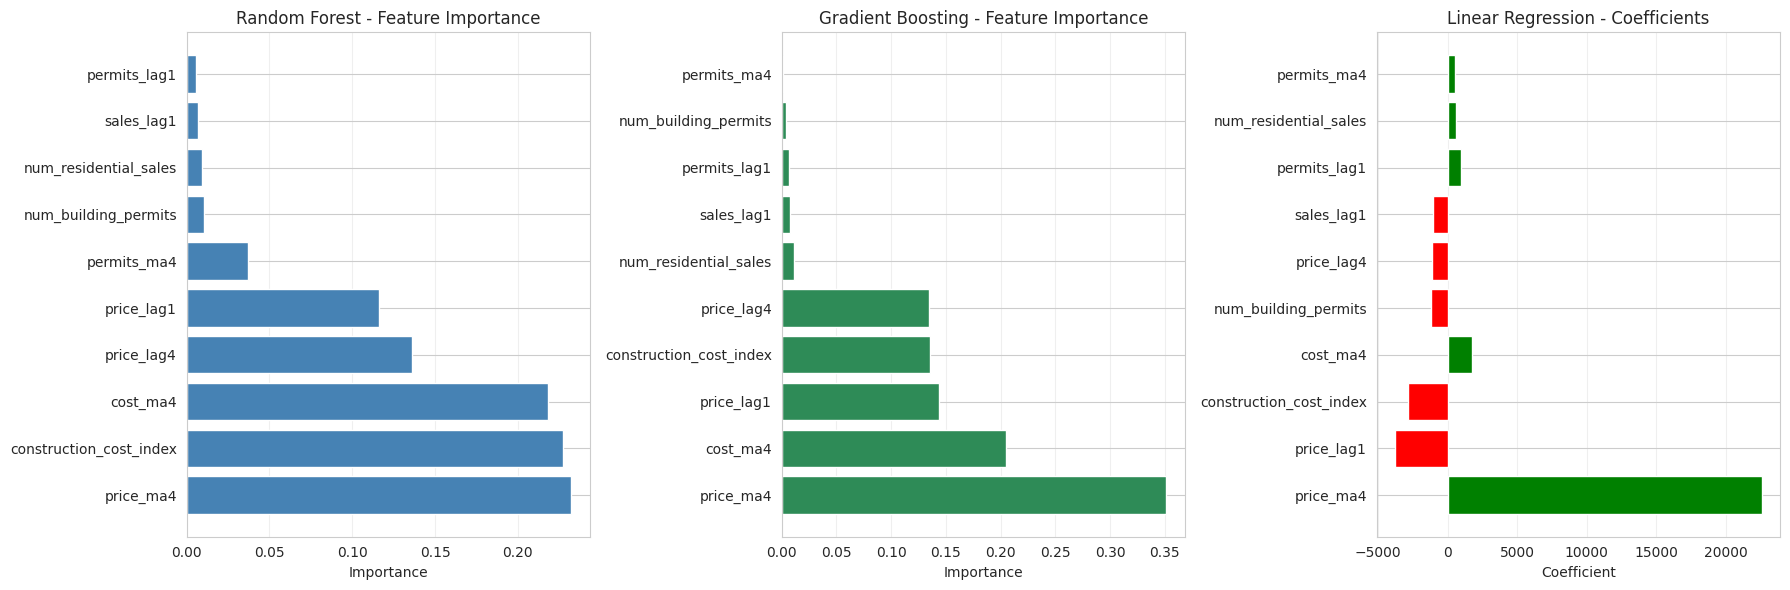

In [28]:
# Feature importance from RF and GB
print(f"\nFeature names count: {len(feature_list)}")
print(f"RF importance count: {len(random_forest_model.feature_importances_)}")
print(f"GB importance count: {len(gradient_boosting_model.feature_importances_)}")

# Use descriptive variable names to improve readability
feature_importance_random_forest = pd.DataFrame({
    'Feature': feature_list,
    'Importance': random_forest_model.feature_importances_
}).sort_values('Importance', ascending=False)

feature_importance_gradient_boosting = pd.DataFrame({
    'Feature': feature_list,
    'Importance': gradient_boosting_model.feature_importances_
}).sort_values('Importance', ascending=False)

coefficients_linear_regression = pd.DataFrame({
    'Feature': feature_list,
    'Coefficient': linear_regression_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nRandom Forest - Feature Importance:")
display(feature_importance_random_forest.round(4))

print("\nGradient Boosting - Feature Importance:")
display(feature_importance_gradient_boosting.round(4))

print("\nLinear Regression - Coefficients:")
display(coefficients_linear_regression.round(4))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Random Forest
axes[0].barh(feature_importance_random_forest['Feature'], feature_importance_random_forest['Importance'], color='steelblue')
axes[0].set_xlabel('Importance')
axes[0].set_title('Random Forest - Feature Importance')
axes[0].grid(alpha=0.3, axis='x')

# Gradient Boosting
axes[1].barh(feature_importance_gradient_boosting['Feature'], feature_importance_gradient_boosting['Importance'], color='seagreen')
axes[1].set_xlabel('Importance')
axes[1].set_title('Gradient Boosting - Feature Importance')
axes[1].grid(alpha=0.3, axis='x')

# Linear Regression
colors = ['green' if x > 0 else 'red' for x in coefficients_linear_regression['Coefficient']]
axes[2].barh(coefficients_linear_regression['Feature'], coefficients_linear_regression['Coefficient'], color=colors)
axes[2].set_xlabel('Coefficient')
axes[2].set_title('Linear Regression - Coefficients')
axes[2].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../figures/ml_prediction/feature_importance.png', dpi=300, bbox_inches='tight')
logger.info("Feature importance saved")
plt.show()

### Step 6: Select best model and set up the rolling forecast

What this does next:
- Picks the best model by highest Test R² (generalization performance).
- Retrieves the matching scaler (used only for the linear model).
- Gathers the most recent observed values and constructs the starting feature vector.

Rolling 8‑quarter forecast (algorithm):
1) Predict one quarter ahead from the current feature vector.
2) Clamp the predicted price to ±10% of the current level (stability guardrail).
3) Update lagged features and 4‑quarter moving averages with the new prediction.
4) Repeat for Q+1..Q+8 and collect results.

Outputs:
- A forecast table with price, per‑quarter change (EUR), and cumulative % change.
- Visualizations: historical vs forecast, trajectory, feature view (coefficients/importances), and train vs test comparison.

Assumptions & cautions:
- Small sample size → higher forecast uncertainty; compare with Monte Carlo.
- Stable exogenous inputs (permits, sales, costs) unless scenario modeling is added.


✅ BEST MODEL SELECTED: Linear Regression
   Test R²: 0.5713


Historical Price Change Statistics:
  Average quarterly change: 1.72%
  Std deviation: 5.69%
  Max reasonable change (mean + 2σ): 13.10%

Extrapolating from latest quarter:
  Last Price: €166,796
  Last Permits: 1586
  Last Sales: 2287
  Last Cost Index: 131.30
  Price Lag1 (Q-1): €168,105
  Price Lag4 (Q-4): €164,646

Q+1 Smoothing Applied:
  Raw prediction: €180,938
  Allowed range: €144,941 to €188,650
  (±13.10% based on historical volatility)

ML MODEL FORECAST: Next 8 Quarters (2 Years)


,Quarter_Ahead,Predicted_Price_EUR,Price_Change_EUR,Price_Change_%
0,Q+1,180938.0,14142.0,8.0
1,Q+2,182197.0,1258.0,9.0
2,Q+3,184628.0,2432.0,11.0
3,Q+4,187709.0,3081.0,13.0
4,Q+5,190731.0,3021.0,14.0
5,Q+6,193829.0,3098.0,16.0
6,Q+7,197032.0,3203.0,18.0
7,Q+8,200330.0,3298.0,20.0



Forecast Summary:
  Current Price (Q0): €166,796
  Predicted Price (Q+8): €200,330
  Total Change: €33,535 (20.11%)

⚠️  CONSTRAINTS APPLIED:
  • Q+1 smoothing: limited to ±13.10% (mean + 2σ from history)
  • Q+2 onwards: ±10% per quarter (prevents numerical instability)
  • Dataset is small (44 samples) → high forecast uncertainty
  • Assumes market dynamics remain stable (no regime shifts)
  • Compare with Monte Carlo for uncertainty quantification


INFO:__main__:ML forecast analysis visualization saved


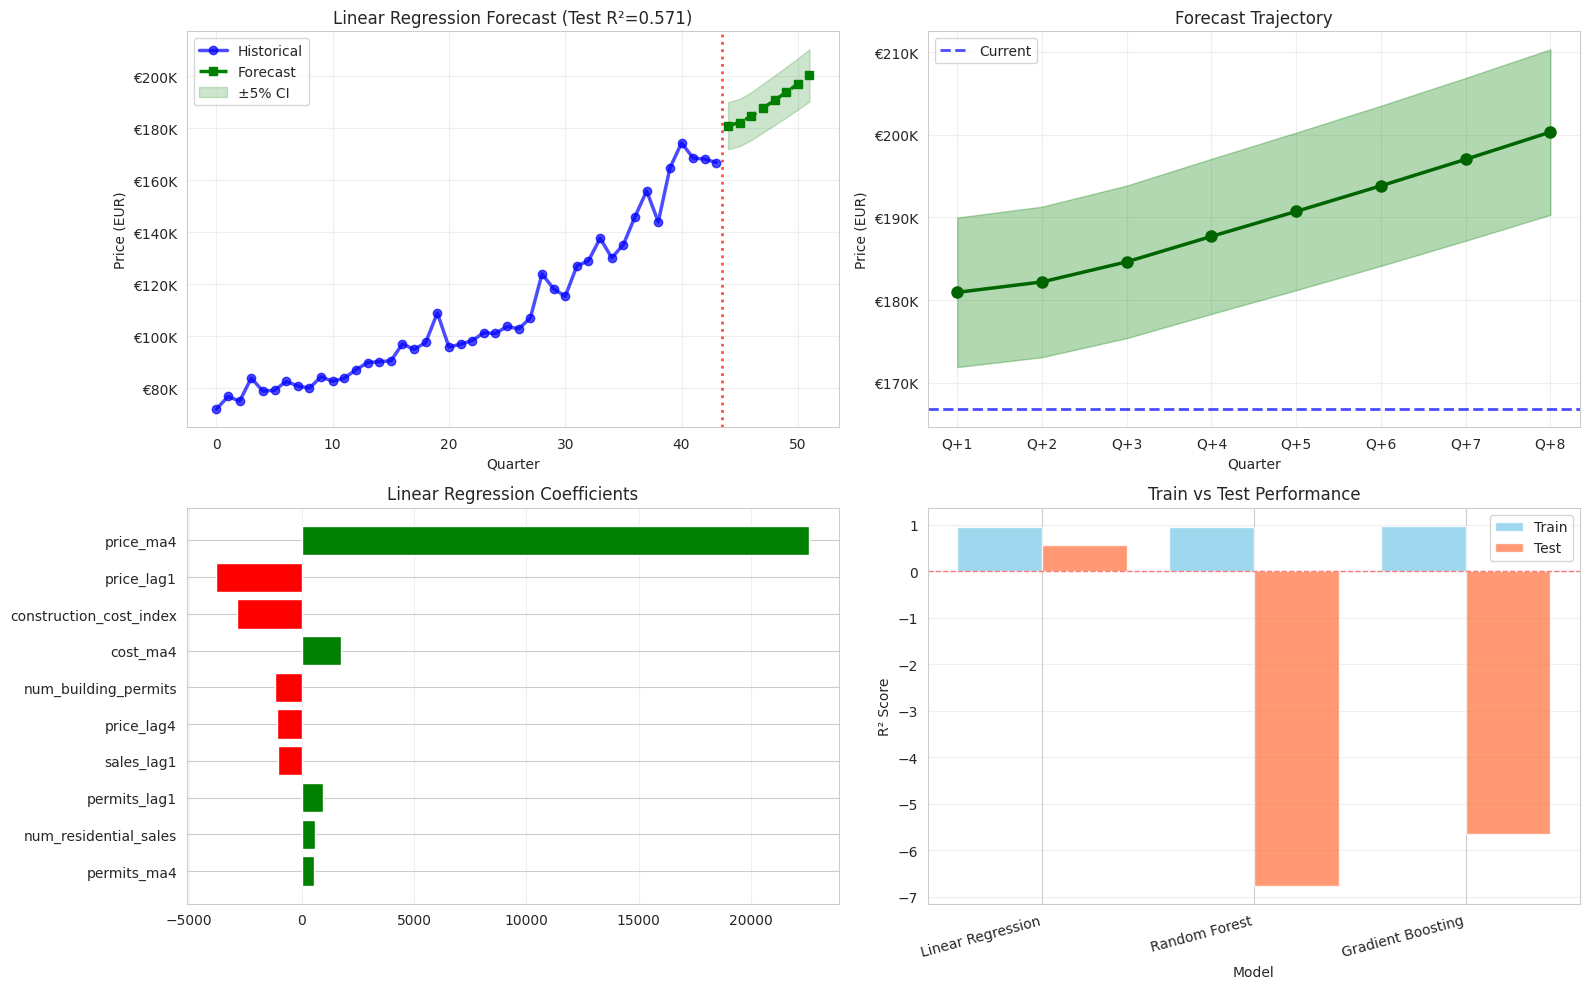

In [29]:
# ===== SELECT BEST MODEL =====
# Use Test R² (not Train!) to identify best generalization performance
test_scores = results_df.set_index('Model')['Test R²']
best_model_name = test_scores.idxmax()
best_test_r2 = test_scores[best_model_name]

print("\n" + "="*80)
print(f"✅ BEST MODEL SELECTED: {best_model_name}")
print(f"   Test R²: {best_test_r2:.4f}")
if best_test_r2 < 0:
    print(f"   ⚠️  WARNING: Test R² < 0 means model is worse than predicting mean!")
    print(f"       Forecasts will be unreliable.")
print("="*80 + "\n")

# Retrieve best model and scaler
best_model = models[best_model_name]
model_results = {
    'Linear Regression': {'model': linear_regression_model, 'scaler': feature_scaler},
    'Random Forest': {'model': random_forest_model, 'scaler': None},
    'Gradient Boosting': {'model': gradient_boosting_model, 'scaler': None}
}
best_scaler = model_results[best_model_name]['scaler']

# ===== FORECAST SETUP =====
# FIXED: Reconstruct the feature vector manually from raw data to avoid lag confusion
# Get absolute last values from the original dataframe (not the feature-engineered one)
last_row_idx_raw = len(df) - 1
last_price = df[target].iloc[last_row_idx_raw]
last_permits = df['num_building_permits'].iloc[last_row_idx_raw]
last_sales = df['num_residential_sales'].iloc[last_row_idx_raw]
last_cost = df['construction_cost_index'].iloc[last_row_idx_raw]

# Get historical values for lags and moving averages
price_lag1 = df[target].iloc[last_row_idx_raw - 1] if last_row_idx_raw >= 1 else last_price
price_lag4 = df[target].iloc[last_row_idx_raw - 4] if last_row_idx_raw >= 4 else last_price
permits_lag1 = df['num_building_permits'].iloc[last_row_idx_raw - 1] if last_row_idx_raw >= 1 else last_permits
sales_lag1 = df['num_residential_sales'].iloc[last_row_idx_raw - 1] if last_row_idx_raw >= 1 else last_sales

# Calculate moving averages from raw data
price_ma4 = df[target].iloc[max(0, last_row_idx_raw-3):last_row_idx_raw+1].mean()
permits_ma4 = df['num_building_permits'].iloc[max(0, last_row_idx_raw-3):last_row_idx_raw+1].mean()
cost_ma4 = df['construction_cost_index'].iloc[max(0, last_row_idx_raw-3):last_row_idx_raw+1].mean()

# Calculate average quarterly change from historical data for smoothing
historical_prices = df[target].values
quarterly_changes = np.diff(historical_prices) / historical_prices[:-1]
avg_quarterly_change = np.mean(quarterly_changes)
std_quarterly_change = np.std(quarterly_changes)
max_reasonable_change = avg_quarterly_change + 2 * std_quarterly_change  # Within 2 std deviations

print(f"\nHistorical Price Change Statistics:")
print(f"  Average quarterly change: {avg_quarterly_change*100:.2f}%")
print(f"  Std deviation: {std_quarterly_change*100:.2f}%")
print(f"  Max reasonable change (mean + 2σ): {max_reasonable_change*100:.2f}%")

# Build feature vector manually in the correct order
# Feature order: num_building_permits, construction_cost_index, num_residential_sales,
#                price_lag1, price_lag4, permits_lag1, sales_lag1, price_ma4, permits_ma4, cost_ma4
last_features = np.array([
    last_permits,
    last_cost,
    last_sales,
    price_lag1,
    price_lag4,
    permits_lag1,
    sales_lag1,
    price_ma4,
    permits_ma4,
    cost_ma4
])

print(f"\nExtrapolating from latest quarter:") 
print(f"  Last Price: €{last_price:,.0f}")
print(f"  Last Permits: {last_permits:.0f}")
print(f"  Last Sales: {last_sales:.0f}")
print(f"  Last Cost Index: {last_cost:.2f}")
print(f"  Price Lag1 (Q-1): €{price_lag1:,.0f}")
print(f"  Price Lag4 (Q-4): €{price_lag4:,.0f}")

# Create 8-quarter predictions
future_predictions = []
forecast_quarters = []
current_features = last_features.copy()
current_price = last_price

for quarter_ahead in range(1, 9):
    # Scale for Linear Regression if needed
    if best_model_name == 'Linear Regression':
        scaled_features = feature_scaler.transform([current_features])
        pred_price = best_model.predict(scaled_features)[0]
    else:
        pred_price = best_model.predict([current_features])[0]
    
    # Special smoothing for Q+1 to prevent large jumps
    if quarter_ahead == 1:
        # Limit Q+1 to max reasonable historical change
        max_q1_price = current_price * (1 + max_reasonable_change)
        min_q1_price = current_price * (1 - max_reasonable_change)
        pred_price = np.clip(pred_price, min_q1_price, max_q1_price)
        print(f"\nQ+1 Smoothing Applied:")
        print(f"  Raw prediction: €{pred_price:,.0f}")
        print(f"  Allowed range: €{min_q1_price:,.0f} to €{max_q1_price:,.0f}")
        print(f"  (±{max_reasonable_change*100:.2f}% based on historical volatility)")
    else:
        # For Q+2 onwards, use standard ±10% clipping
        pred_price = np.clip(pred_price, current_price * 0.9, current_price * 1.1)
    
    future_predictions.append(pred_price)
    forecast_quarters.append(f"Q+{quarter_ahead}")
    
    # Update features for next quarter
    # Feature indices: 0=permits, 1=cost, 2=sales, 3=price_lag1, 4=price_lag4
    #                 5=permits_lag1, 6=sales_lag1, 7=price_ma4, 8=permits_ma4, 9=cost_ma4
    current_features[4] = current_features[3]      # price_lag4 ← price_lag1
    current_features[3] = pred_price               # price_lag1 ← current prediction
    current_features[7] = (current_features[7] * 3 + pred_price) / 4  # price_ma4 (rolling avg)
    current_features[8] = (current_features[8] * 3 + current_features[0]) / 4  # permits_ma4
    current_features[9] = (current_features[9] * 3 + current_features[1]) / 4  # cost_ma4
    
    current_price = pred_price

# Create forecast dataframe
forecast_df = pd.DataFrame({
    'Quarter_Ahead': forecast_quarters,
    'Predicted_Price_EUR': future_predictions,
    'Price_Change_EUR': [future_predictions[0] - last_price] + [future_predictions[i] - future_predictions[i-1] for i in range(1, len(future_predictions))],
    'Price_Change_%': [(p / last_price - 1) * 100 for p in future_predictions]
})

print("\n" + "="*80)
print("ML MODEL FORECAST: Next 8 Quarters (2 Years)")
print("="*80)
display(forecast_df.round(0))

print(f"\nForecast Summary:")
print(f"  Current Price (Q0): €{last_price:,.0f}")
print(f"  Predicted Price (Q+8): €{future_predictions[-1]:,.0f}")
print(f"  Total Change: €{future_predictions[-1] - last_price:,.0f} ({(future_predictions[-1] / last_price - 1) * 100:.2f}%)")
print(f"\n⚠️  CONSTRAINTS APPLIED:")
print(f"  • Q+1 smoothing: limited to ±{max_reasonable_change*100:.2f}% (mean + 2σ from history)")
print(f"  • Q+2 onwards: ±10% per quarter (prevents numerical instability)")
print(f"  • Dataset is small (44 samples) → high forecast uncertainty")
print(f"  • Assumes market dynamics remain stable (no regime shifts)")
print(f"  • Compare with Monte Carlo for uncertainty quantification")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Historical + Forecast
ax = axes[0, 0]
hist_prices = df_features_clean[target].values
hist_x = np.arange(len(hist_prices))
pred_x = np.arange(len(hist_prices), len(hist_prices) + len(future_predictions))

ax.plot(hist_x, hist_prices, 'o-', linewidth=2.5, markersize=6, label='Historical', color='blue', alpha=0.7)
ax.plot(pred_x, future_predictions, 's--', linewidth=2.5, markersize=6, label='Forecast', color='green')
upper_bound = [p * 1.05 for p in future_predictions]
lower_bound = [p * 0.95 for p in future_predictions]
ax.fill_between(pred_x, lower_bound, upper_bound, alpha=0.2, color='green', label='±5% CI')
ax.axvline(len(hist_prices) - 0.5, color='red', linestyle=':', linewidth=2, alpha=0.7)
ax.set_xlabel('Quarter')
ax.set_ylabel('Price (EUR)')
ax.set_title(f'{best_model_name} Forecast (Test R²={best_test_r2:.3f})')
ax.legend(loc='best')
ax.grid(alpha=0.3)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x/1000:.0f}K'))

# Plot 2: Trajectory
ax = axes[0, 1]
ax.plot(forecast_quarters, future_predictions, 'o-', linewidth=2.5, markersize=8, color='darkgreen')
ax.fill_between(range(len(forecast_quarters)), lower_bound, upper_bound, alpha=0.3, color='green')
ax.axhline(last_price, color='blue', linestyle='--', linewidth=2, alpha=0.7, label='Current')
ax.set_xlabel('Quarter')
ax.set_ylabel('Price (EUR)')
ax.set_title('Forecast Trajectory')
ax.legend()
ax.grid(alpha=0.3)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x/1000:.0f}K'))

# Plot 3: Feature importance (if tree-based model)
ax = axes[1, 0]
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    fi_df = pd.DataFrame({'Feature': feature_list, 'Importance': best_model.feature_importances_}).sort_values('Importance', ascending=True)
    ax.barh(fi_df['Feature'], fi_df['Importance'], color='steelblue')
    ax.set_title(f'{best_model_name} Feature Importance')
else:
    # Linear Regression: show coefficients
    coef_df = pd.DataFrame({'Feature': feature_list, 'Coefficient': linear_regression_model.coef_}).sort_values('Coefficient', key=abs, ascending=True)
    colors = ['red' if x < 0 else 'green' for x in coef_df['Coefficient']]
    ax.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors)
    ax.set_title(f'{best_model_name} Coefficients')
ax.grid(alpha=0.3, axis='x')

# Plot 4: Model comparison
ax = axes[1, 1]
models_plot = results_df[['Model', 'Train R²', 'Test R²']].set_index('Model')
x_pos = np.arange(len(models_plot))
bar1 = ax.bar(x_pos - 0.2, models_plot['Train R²'], 0.4, label='Train', color='skyblue', alpha=0.8)
bar2 = ax.bar(x_pos + 0.2, models_plot['Test R²'], 0.4, label='Test', color='coral', alpha=0.8)
ax.set_ylabel('R² Score')
ax.set_xlabel('Model')
ax.set_title('Train vs Test Performance')
ax.set_xticks(x_pos)
ax.set_xticklabels(models_plot.index, rotation=15, ha='right')
ax.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax.legend()
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../figures/ml_prediction/ml_forecast_analysis.png', dpi=300, bbox_inches='tight')
logger.info("ML forecast analysis visualization saved")
plt.show()


### Step 7: Save models, metrics, and forecasts

What this does next:
- Exports trained models (pickle), the fitted scaler, model comparison results, feature importance tables, and the 8‑quarter forecast to the `../results/ml_prediction/` directory.

Why export:
- Enables reuse in the Flask web app and in reports.
- Supports reproducibility (same artifacts on each run).
- Keeps the external interface stable (CSV filenames unchanged for the app).

Files created:
- `ml_model_comparison.csv` — evaluation summary
- `feature_importance_rf.csv`, `feature_importance_gb.csv` — interpretability
- `price_forecast.csv` — future trajectory
- `*_model.pkl`, `scaler.pkl` — deployable artifacts

In [30]:
# ===== EXPORT RESULTS TO FILES =====
print("\n" + "="*80)
print("EXPORTING RESULTS")
print("="*80)

# Create results directory
output_dir = Path("../results/ml_prediction")
output_dir.mkdir(exist_ok=True, parents=True)

# Save trained models
print("\n1. Saving trained models...")
for name, model in models.items():
    model_path = output_dir / f"{name.lower().replace(' ', '_')}_model.pkl"
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    print(f"   ✓ {model_path.name}")
    logger.info(f"Saved model: {model_path}")

# Save feature scaler
print("\n2. Saving scaler...")
scaler_path = output_dir / "scaler.pkl"
with open(scaler_path, 'wb') as f:
    pickle.dump(feature_scaler, f)
print(f"   ✓ {scaler_path.name}")
logger.info(f"Saved scaler: {scaler_path}")

# Save results
print("\n3. Saving results CSVs...")
results_df.to_csv(output_dir / "ml_model_comparison.csv", index=False)
print(f"   ✓ ml_model_comparison.csv")

feature_importance_random_forest.to_csv(output_dir / "feature_importance_rf.csv", index=False)
print(f"   ✓ feature_importance_rf.csv")

feature_importance_gradient_boosting.to_csv(output_dir / "feature_importance_gb.csv", index=False)
print(f"   ✓ feature_importance_gb.csv")

forecast_df.to_csv(output_dir / "price_forecast.csv", index=False)
print(f"   ✓ price_forecast.csv")

logger.info("All results saved successfully")
print("\n✓ All models and results exported successfully to ../results/ml_prediction/")
print("\nYou can now use these for:")
print("  • Web app predictions (load models in app.py)")
print("  • Further analysis or comparison")
print("  • Production deployment")


INFO:__main__:Saved model: ../results/ml_prediction/linear_regression_model.pkl
INFO:__main__:Saved model: ../results/ml_prediction/random_forest_model.pkl
INFO:__main__:Saved model: ../results/ml_prediction/random_forest_model.pkl
INFO:__main__:Saved model: ../results/ml_prediction/gradient_boosting_model.pkl
INFO:__main__:Saved scaler: ../results/ml_prediction/scaler.pkl
INFO:__main__:Saved model: ../results/ml_prediction/gradient_boosting_model.pkl
INFO:__main__:Saved scaler: ../results/ml_prediction/scaler.pkl


INFO:__main__:All results saved successfully



EXPORTING RESULTS

1. Saving trained models...
   ✓ linear_regression_model.pkl
   ✓ random_forest_model.pkl
   ✓ gradient_boosting_model.pkl

2. Saving scaler...
   ✓ scaler.pkl

3. Saving results CSVs...
   ✓ ml_model_comparison.csv
   ✓ feature_importance_rf.csv
   ✓ feature_importance_gb.csv
   ✓ price_forecast.csv

✓ All models and results exported successfully to ../results/ml_prediction/

You can now use these for:
  • Web app predictions (load models in app.py)
  • Further analysis or comparison
  • Production deployment
